# Comparison: SVR vs Regularization Network

This notebook compares two kernel-based regression methods on the non-linear `function_a` dataset:

### *Datasets* (`function_a`)
- **Dataset 1**: 50 points (small)
- **Dataset 2**: 100 points (medium)
- **Dataset 3**: 1000 points (large) 

--> Objective : show difference in **computation time** and **accuracy**

### *Regressions*
1. **Support Vector Regression (SVR)**
   - Uses **ε-insensitive loss**: ignores errors smaller than ε = 1.5
   - **Sparse solution**: only support vectors contribute to the model
   - Optimization: **Quadratic Programming** (QP)

2. **Regularization Network (Kernel Ridge Regression)**
   - Uses **quadratic loss**: penalizes all errors
   - **Dense solution**: all training points contribute to the model
   - Optimization: Solving a **linear system** $(K + \lambda I) c = y$

### *Key differences to observe:*
- Sparsity: SVR uses subset of points vs. Regularization Network uses all points
- Fitting behavior: ε-tube vs. minimizing squared error
- Speed: How training time scales with dataset size

In [95]:
%load_ext autoreload
%autoreload 2

# Third party libraries imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Local imports
from sv_machines.datasets.function_a import get_function_a_dataset, get_function_a_plot, function_a
from sv_machines.datasets.utils import add_prediction_function_to_plot

# Scikit-learn imports
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load a `function_a` dataset

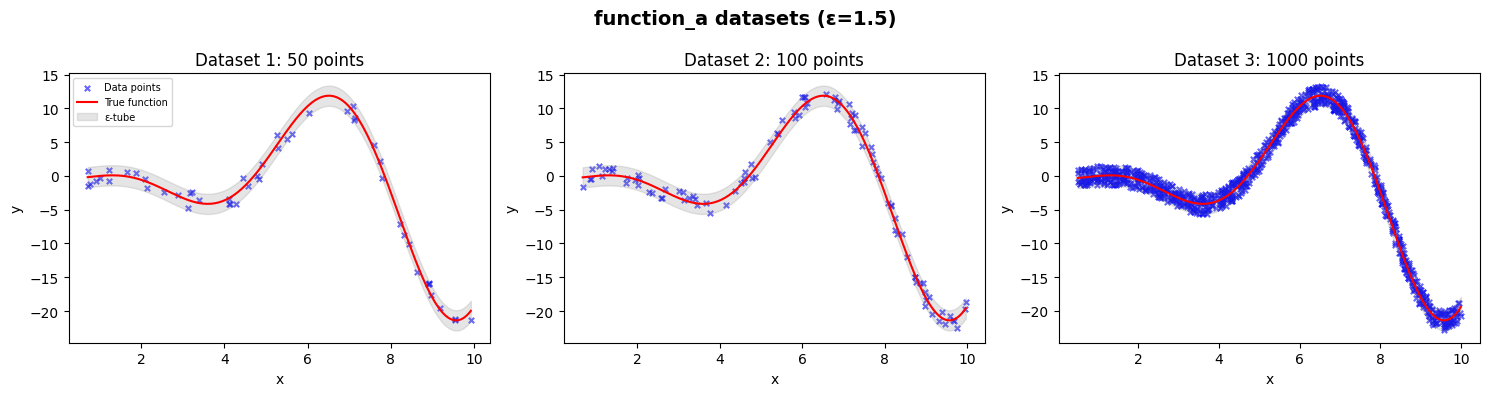

In [96]:
# Dataset
epsilon = 1.5
dataset_sizes = [50, 100, 1000]  # Three dataset sizes to compare

# Generate all datasets
datasets = {}
for n_points in dataset_sizes:
    x_data, y_data = get_function_a_dataset(
        epsilon=epsilon, num_points=n_points, epsilon_strict=True
    )
    datasets[n_points] = {
        'x_data': x_data,
        'y_data': y_data,
        'X_train': x_data.reshape(-1, 1),
        'y_train': y_data
    }

# Plot all datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, n_points in enumerate(dataset_sizes):
    ax = axes[idx]
    x_data = datasets[n_points]['x_data']
    y_data = datasets[n_points]['y_data']
    
    x_true = np.linspace(min(x_data), max(x_data), 200)
    y_true = function_a(x_true)
    
    ax.scatter(x_data, y_data, marker='x', s=15, color='blue', alpha=0.6, label='Data points')
    ax.plot(x_true, y_true, 'r-', linewidth=1.5, label='True function')
    ax.fill_between(x_true, y_true - epsilon, y_true + epsilon, color='gray', alpha=0.2, label='ε-tube')
    ax.set_title(f"Dataset {idx+1}: {n_points} points")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if idx == 0:
        ax.legend(loc='upper left', fontsize=7)

fig.suptitle(f"function_a datasets (ε={epsilon})", fontsize=14, fontweight='bold')
fig.tight_layout()





# 1. Perfom $\varepsilon$ "soft" support vector regression on the dataset
Using a RBF kernel of parameter $\gamma$ = 0.5, SVR minimizes:
$$\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^*} \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)$$


###  SVR set up and training :


In [97]:
# SVR parameters
C_svr = 100  
epsilon_svr = epsilon
gamma_svr = 0.5

# Train SVR on all datasets
svr_results = {}
for n_points in dataset_sizes:
    X_train = datasets[n_points]['X_train']
    y_train = datasets[n_points]['y_train']
    
    svr_model = SVR(kernel='rbf', C=C_svr, epsilon=epsilon_svr, gamma=gamma_svr)
    
    start_time = time.perf_counter()
    svr_model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time
    
    svr_results[n_points] = {
        'model': svr_model,
        'training_time': training_time,
        'support_vectors_idx': svr_model.support_,
        'n_support_vectors': len(svr_model.support_)
    }

# Display results
print(f"SVR Parameters: C={C_svr}, ε={epsilon_svr}, γ={gamma_svr}")
print("=" * 65)
print(f"{'Dataset':<15} {'Training Time':<18} {'Support Vectors':<20} {'Sparsity':<12}")
print("-" * 65)
for n_points in dataset_sizes:
    r = svr_results[n_points]
    sparsity = 100 * (1 - r['n_support_vectors'] / n_points)
    print(f"{n_points} points{'':<7} {r['training_time']*1000:>10.3f} ms{'':<5} {r['n_support_vectors']:>5} / {n_points:<10} {sparsity:>6.1f}%")
print("=" * 65)

SVR Parameters: C=100, ε=1.5, γ=0.5
Dataset         Training Time      Support Vectors      Sparsity    
-----------------------------------------------------------------
50 points             0.777 ms          9 / 50           82.0%
100 points             0.465 ms          8 / 100          92.0%
1000 points             4.029 ms         10 / 1000         99.0%


# 2. Regularization Network (Kernel Ridge Regression)

The Regularization Network minimizes:
$$\min_{\mathbf{c}} \sum_{i=1}^{n} (y_i - f(x_i))^2 + \lambda \|\mathbf{c}\|^2_K$$

Where $f(x) = \sum_{j=1}^n c_j K(x, x_j)$ with $K$ being the kernel function.

The solution is obtained by solving the **linear system**:
$$(K + \lambda I) \mathbf{c} = \mathbf{y}$$

### Set up and training


In [99]:
# Regularization Network parameters
alpha_krr = 0.1
gamma_krr = gamma_svr  # Same kernel parameter as SVR

# Train Kernel Ridge on all datasets
krr_results = {}
for n_points in dataset_sizes:
    X_train = datasets[n_points]['X_train']
    y_train = datasets[n_points]['y_train']
    
    krr_model = KernelRidge(kernel='rbf', alpha=alpha_krr, gamma=gamma_krr)
    
    start_time = time.perf_counter()
    krr_model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time
    
    krr_results[n_points] = {
        'model': krr_model,
        'training_time': training_time
    }

# Display results
print(f"Kernel Ridge Parameters: α={alpha_krr}, γ={gamma_krr}")
print("=" * 50)
print(f"{'Dataset':<15} {'Training Time':<18} {'Points Used':<15}")
print("-" * 50)
for n_points in dataset_sizes:
    r = krr_results[n_points]
    print(f"{n_points} points{'':<7} {r['training_time']*1000:>10.3f} ms{'':<5} {n_points} (100%)")
print("=" * 50)


Kernel Ridge Parameters: α=0.1, γ=0.5
Dataset         Training Time      Points Used    
--------------------------------------------------
50 points             1.056 ms      50 (100%)
100 points             1.417 ms      100 (100%)
1000 points            48.127 ms      1000 (100%)


## 3. Side-by-Side Comparison


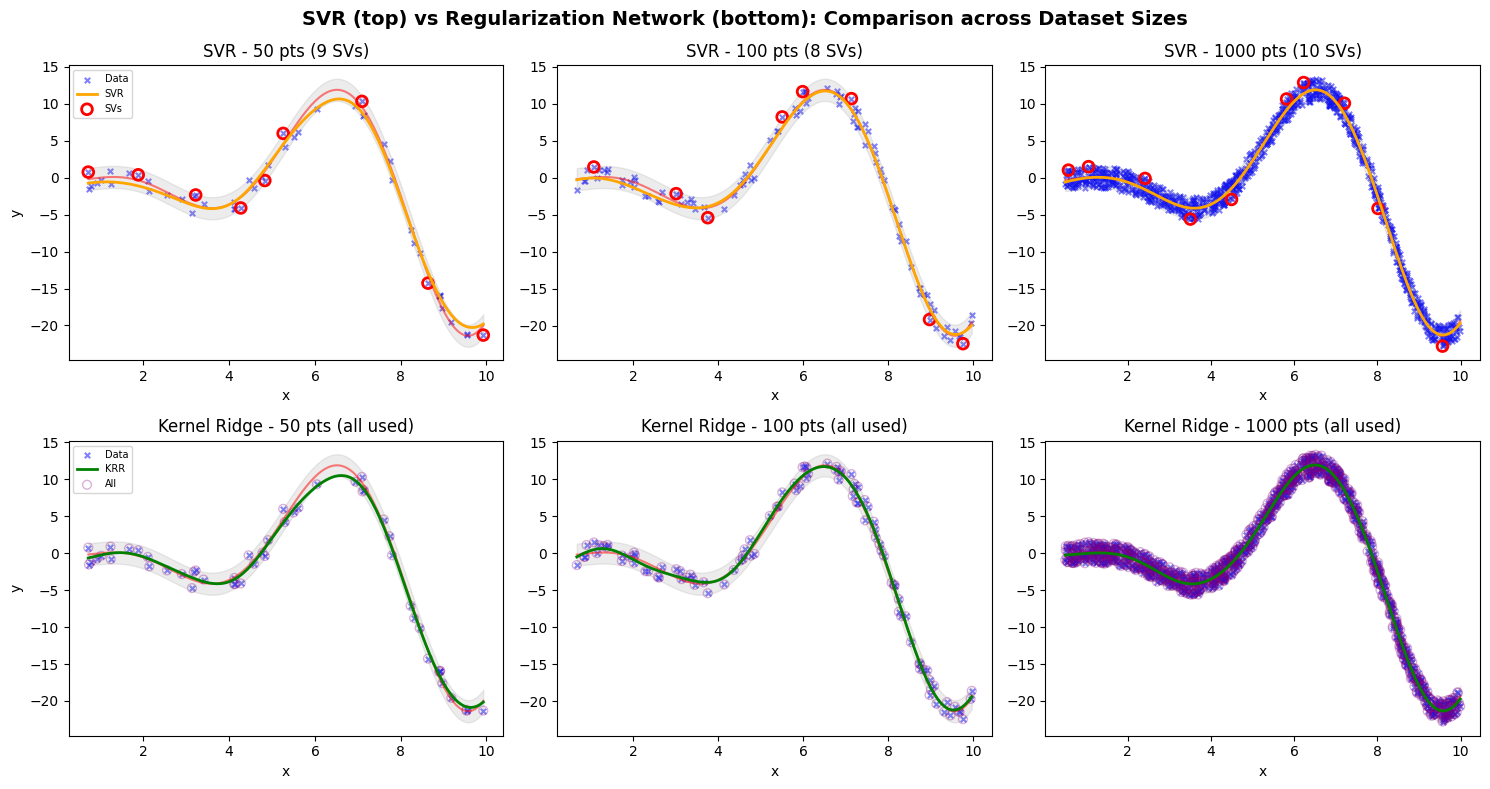

In [100]:
# Side-by-side comparison for all datasets (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, n_points in enumerate(dataset_sizes):
    x_data = datasets[n_points]['x_data']
    y_data = datasets[n_points]['y_data']
    X_train = datasets[n_points]['X_train']
    y_train = datasets[n_points]['y_train']
    
    svr_model = svr_results[n_points]['model']
    krr_model = krr_results[n_points]['model']
    support_vectors_idx = svr_results[n_points]['support_vectors_idx']
    n_sv = svr_results[n_points]['n_support_vectors']
    
    x_true = np.linspace(min(x_data), max(x_data), 200)
    y_true = function_a(x_true)
    x_plot = x_true.reshape(-1, 1)
    
    # Top row: SVR
    ax = axes[0, idx]
    ax.scatter(x_data, y_data, marker='x', s=15, color='blue', alpha=0.5, label='Data')
    ax.plot(x_true, y_true, 'r-', linewidth=1.5, alpha=0.5)
    ax.fill_between(x_true, y_true - epsilon, y_true + epsilon, color='gray', alpha=0.15)
    ax.plot(x_plot, svr_model.predict(x_plot), 'orange', linewidth=2, label='SVR')
    ax.scatter(X_train[support_vectors_idx], y_train[support_vectors_idx], 
               s=60, facecolors='none', edgecolors='red', linewidths=2, label='SVs')
    ax.set_title(f"SVR - {n_points} pts ({n_sv} SVs)")
    ax.set_xlabel('x')
    if idx == 0:
        ax.set_ylabel('y')
        ax.legend(loc='upper left', fontsize=7)
    
    # Bottom row: Kernel Ridge
    ax = axes[1, idx]
    ax.scatter(x_data, y_data, marker='x', s=15, color='blue', alpha=0.5, label='Data')
    ax.plot(x_true, y_true, 'r-', linewidth=1.5, alpha=0.5)
    ax.fill_between(x_true, y_true - epsilon, y_true + epsilon, color='gray', alpha=0.15)
    ax.plot(x_plot, krr_model.predict(x_plot), 'green', linewidth=2, label='KRR')
    ax.scatter(X_train, y_train, s=40, facecolors='none', edgecolors='purple', 
               linewidths=1, alpha=0.3, label='All')
    ax.set_title(f"Kernel Ridge - {n_points} pts (all used)")
    ax.set_xlabel('x')
    if idx == 0:
        ax.set_ylabel('y')
        ax.legend(loc='upper left', fontsize=7)

fig.suptitle("SVR (top) vs Regularization Network (bottom): Comparison across Dataset Sizes", 
             fontsize=14, fontweight='bold')
fig.tight_layout()


## 4. Quantitative Comparison
### MSE and MAE of the two trained models versus the true values


In [102]:
# Compute prediction errors for all datasets
print("=" * 90)
print("FULL COMPARISON: SVR vs Regularization Network across all Dataset Sizes")
print("=" * 90)

for n_points in dataset_sizes:
    x_data = datasets[n_points]['x_data']
    X_train = datasets[n_points]['X_train']
    y_true_train = function_a(x_data)
    
    svr_model = svr_results[n_points]['model']
    krr_model = krr_results[n_points]['model']
    
    # SVR metrics
    svr_pred = svr_model.predict(X_train)
    svr_mse = np.mean((svr_pred - y_true_train)**2)
    svr_mae = np.mean(np.abs(svr_pred - y_true_train))
    svr_time = svr_results[n_points]['training_time'] * 1000
    n_sv = svr_results[n_points]['n_support_vectors']
    
    # Kernel Ridge metrics
    krr_pred = krr_model.predict(X_train)
    krr_mse = np.mean((krr_pred - y_true_train)**2)
    krr_mae = np.mean(np.abs(krr_pred - y_true_train))
    krr_time = krr_results[n_points]['training_time'] * 1000
    
    print(f"\n>>> Dataset: {n_points} points")
    print("-" * 70)
    print(f"{'Metric':<25} {'SVR':<22} {'Kernel Ridge':<22}")
    print("-" * 70)
    print(f"{'Training time (ms)':<25} {svr_time:<22.3f} {krr_time:<22.3f}")
    print(f"{'Points used':<25} {n_sv:<22} {n_points:<22}")
    print(f"{'Sparsity':<25} {100*(1-n_sv/n_points):.1f}%{'':<17} {'0.0%':<22}")
    print(f"{'MSE (vs true)':<25} {svr_mse:<22.6f} {krr_mse:<22.6f}")
    print(f"{'MAE (vs true)':<25} {svr_mae:<22.6f} {krr_mae:<22.6f}")

print("\n" + "=" * 90)

# Summary table: Training time scaling
print("\n>>> TRAINING TIME SUMMARY (ms)")
print("-" * 50)
print(f"{'Dataset':<15} {'SVR':<15} {'Kernel Ridge':<15}")
print("-" * 50)
for n_points in dataset_sizes:
    svr_t = svr_results[n_points]['training_time'] * 1000
    krr_t = krr_results[n_points]['training_time'] * 1000
    print(f"{n_points} points{'':<6} {svr_t:<15.3f} {krr_t:<15.3f}")
print("-" * 50)


FULL COMPARISON: SVR vs Regularization Network across all Dataset Sizes

>>> Dataset: 50 points
----------------------------------------------------------------------
Metric                    SVR                    Kernel Ridge          
----------------------------------------------------------------------
Training time (ms)        0.777                  1.056                 
Points used               9                      50                    
Sparsity                  82.0%                  0.0%                  
MSE (vs true)             0.342670               0.192140              
MAE (vs true)             0.468413               0.356401              

>>> Dataset: 100 points
----------------------------------------------------------------------
Metric                    SVR                    Kernel Ridge          
----------------------------------------------------------------------
Training time (ms)        0.465                  1.417                 
Points used        